In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

#### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [4]:
data = df.resample('W').mean()

In [5]:
data.head(5)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


При недельном семплинге нам нужно удалить ряд лишних признаков, относящихся к дням и часам. Про признак года мы говорили на уроке

In [6]:
data.drop(['month', 'hour', 'year', 'dayofweek', 'dayofyear', 'dayofmonth'], axis=1, inplace=True)

Признаки праздников могут быть важны даже в разрезе недели. 

In [7]:
data.loc[data['is_holiday'] > 0, 'is_holiday'] = 1
data.loc[data['is_prev_holiday'] > 0, 'is_prev_holiday'] = 1
data.loc[data['is_next_holiday'] > 0, 'is_next_holiday'] = 1

In [8]:
data = pd.get_dummies(data, columns=['is_holiday', 'is_prev_holiday', 'is_next_holiday'])

#### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [9]:
steps = np.linspace(0.01, 0.09, 9).round(2)
for step in steps:
     data['exp_'+str(step)] = exponential_smoothing(data['PJME_MW'], step)

In [10]:
data['d_26'] = data['PJME_MW'].rolling(window=26).mean()
data['d_52'] = data['PJME_MW'].rolling(window=52).mean()
data['diff1'] = data['PJME_MW'].diff(1)
data['diff1_d'] = data['diff1'] / data['PJME_MW']
data['diff1_l'] = np.log(data['diff1'])
data.fillna(0, inplace=True)

C:\Users\Pavel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [11]:
p = 13
for i in range(p):
    data['t'+str(p-i)]=0
    data['t'+str(p-i)].values[p:] = data['PJME_MW'].values[i:-(p)+i]

for i in range(p):
    data['d'+str(p-i)]=0
    data['d'+str(p-i)].values[p:] = data['diff1'].values[i:-(p)+i]

C:\Users\Pavel\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


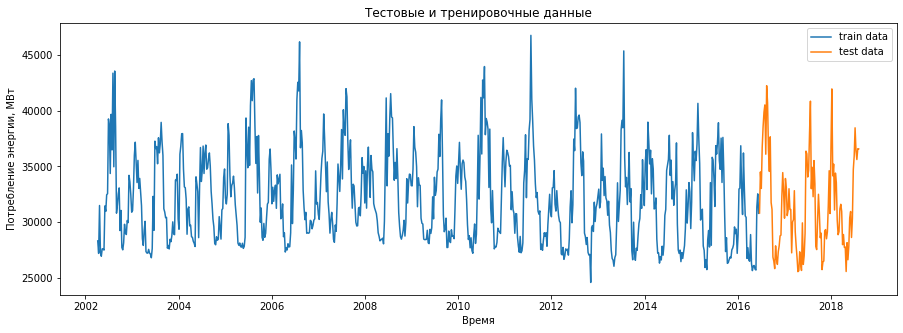

In [12]:
h = 4
train, test = split_data( data[13:], '15-06-2016')
X_train_h4 = train.iloc[:-h, :]
y_train_h4 = train['PJME_MW'].values[h:]
X_test_h4 = test.iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]

plt.figure( figsize=( 15, 5 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
model_h4 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [15]:
model_h4.fit( X_train_h4, y_train_h4 )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [16]:
y_test_pred_h4 = model_h4.predict(X_test_h4)

In [17]:
X_test_h4.shape, y_test_pred_h4.shape

((108, 49), (108,))

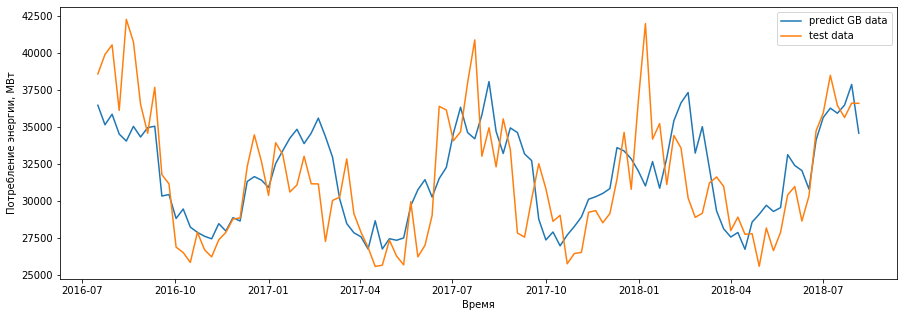

In [18]:
plt.figure( figsize=( 15, 5 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h:],y_test_pred_h4, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [19]:
mean_absolute_percentage_error(y_test, y_test_pred_h4)

7.489109846406469

In [20]:
from sklearn.feature_selection import SelectFromModel

In [21]:
params = SelectFromModel(model_h4, max_features=8)

In [22]:
params.fit(X_train_h4, y_train_h4)

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9,
                                                    criterion='friedman_mse',
                                                    init=None,
                                                    learning_rate=0.1,
                                                    loss='ls', max_depth=5,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                                                    

In [23]:
data.columns[np.where(params.get_support())[0]]

Index(['PJME_MW', 'weekofyear', 'd_26', 'd_52', 't10', 't9', 't8', 't7'], dtype='object')

#### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [24]:
h = 1
train, test = split_data( data[13:], '15-06-2016')
X_train = train.iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]

model_h1 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_h1.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [25]:
y_test_pred_h1 = model_h1.predict(X_test)

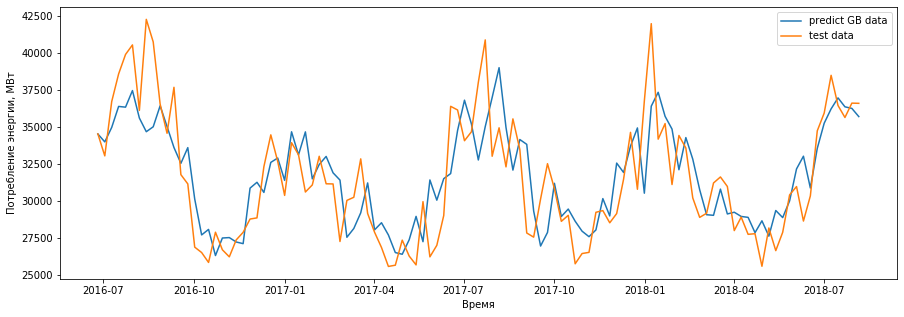

In [26]:
plt.figure( figsize=( 15, 5 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h:],y_test_pred_h1, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [27]:
mean_absolute_percentage_error(y_test, y_test_pred_h1) 

6.349480666134702

#### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
#### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

In [28]:
features = ['PJME_MW', 'weekofyear', 'd_26', 'd_52', 't10', 't9', 't8', 't7']

In [29]:
h = 4

X_train = train[features].iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test[features].iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]

model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)
y_test_pred = model_gb.predict(X_test)

In [30]:
n = 100

X_test_ar = X_test.copy()
y_test_ar = y_test.copy()

In [31]:
#for i in range(p, n):
    #print(i)
for i in range(n):
    
    y_test_ar[i] = model_gb.predict(X_test_ar.iloc[i:i+1, :])
    X_test_ar.iloc[i+h, 0] = y_test_ar[i]
    
       
    if i+h > 26:
         X_test_ar.iloc[i+h, 2] = np.mean(X_test_ar.iloc[i+h-26: i+h, 0])
   
    if i+h > 52:
        X_test_ar.iloc[i+h, 3] = np.mean(X_test_ar.iloc[i+h-52: i+h, 0])
    
    if i > p:
        X_test_ar.iloc[i+h, 4] = X_test_ar.iloc[i+h-10, 0]
        X_test_ar.iloc[i+h, 5] = X_test_ar.iloc[i+h-9, 0]
        X_test_ar.iloc[i+h, 6] = X_test_ar.iloc[i+h-8, 0]
        X_test_ar.iloc[i+h, 7] = X_test_ar.iloc[i+h-7, 0]
    
       

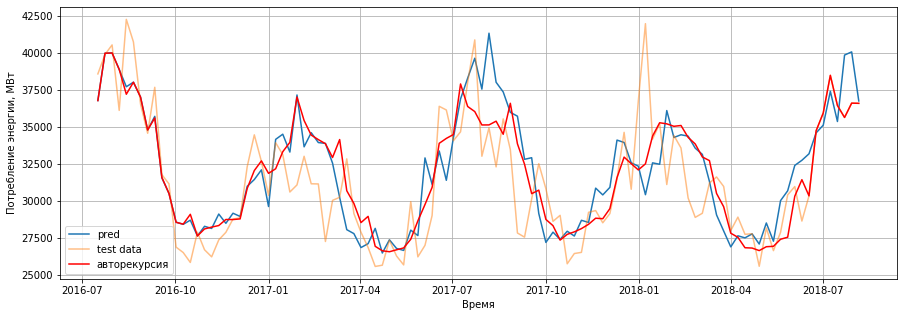

In [32]:
plt.figure( figsize=( 15, 5 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h:],y_test_pred, label='pred' )
plt.plot(test.index[h:],y_test,  label='test data', alpha=0.5)
plt.plot(test.index[h:],y_test_ar, '-r',label='авторекурсия')
plt.legend()
plt.grid()
plt.show()

In [33]:
mean_absolute_percentage_error(y_test, y_test_ar), mean_absolute_percentage_error(y_test, y_test_pred), 

(5.641814354326699, 6.829589147841652)

#### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

In [45]:
error_ar = []
error = []
for i in range(0, 100, 10):
    error.append(mean_absolute_percentage_error(y_test[i:i+9], y_test_pred[i:i+9])) 
    error_ar.append(mean_absolute_percentage_error(y_test[i:i+9], y_test_ar[i:i+9])) 

error_ar

    

[4.444177693644622,
 5.408735667957312,
 5.856543911470659,
 9.56662287799934,
 6.018722864095486,
 6.166535618733181,
 6.382899811284074,
 5.609985569867693,
 8.457877398861683,
 3.8250906228883137]

#### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда

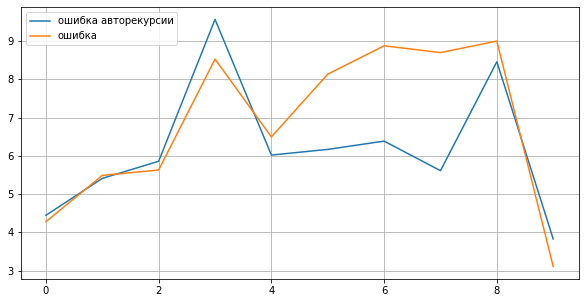

In [51]:
plt.figure(figsize=(10,5))
plt.plot(error_ar, label='ошибка авторекурсии')
plt.plot(error, label='ошибка')
plt.legend()
plt.grid()


In [48]:
np.var(error_ar), np.var(error),

(2.630797163085334, 4.070356339361334)

помимо того, что ошибка в целом снизилась, у рекурсивной модели ниже разброс ошибок по участкам.